# Importing and Installing Libraries

In [1]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut 
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from scipy.spatial import ConvexHull
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

import h5py

import nibabel as nib
import SimpleITK as sitk
import sys
import time
import os
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Load nifti files

In [2]:
new_img = sitk.ReadImage('BraTS20_Training_001_flair.nii')
print(new_img.GetDepth())

155


# Convert Nifti file to dicom series

In [3]:
import SimpleITK as sitk

import sys
import time
import os
import numpy as np

pixel_dtypes = {"int16": np.int16,
                "float64": np.float64}


def writeSlices(series_tag_values, new_img, out_dir, i):
    image_slice = new_img[:, :, i]

    list(map(lambda tag_value: image_slice.SetMetaData(tag_value[0],
                                                       tag_value[1]),
             series_tag_values))

    image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d"))
    image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S"))

    # Setting the type to CT so that the slice location is preserved and
    # the thickness is carried over.
    image_slice.SetMetaData("0008|0060", "CT")

    # (0020, 0032) image position patient determines the 3D spacing between
    # slices.
    #   Image Position (Patient)
    image_slice.SetMetaData("0020|0032", '\\'.join(
        map(str, new_img.TransformIndexToPhysicalPoint((0, 0, i)))))
    #   Instance Number
    image_slice.SetMetaData("0020,0013", str(i))

    # Write to the output directory and add the extension dcm, to force
    # writing in DICOM format.
    writer.SetFileName(os.path.join(out_dir, str(i) + '.dcm'))
    writer.Execute(image_slice)

# Create a new series from a numpy array
try:
    pixel_dtype = pixel_dtypes["float64"]
except KeyError:
    pixel_dtype = pixel_dtypes["int16"]


writer = sitk.ImageFileWriter()
# Use the study/series/frame of reference information given in the meta-data
# dictionary and not the automatically generated information from the file IO
writer.KeepOriginalImageUIDOn()




if pixel_dtype == np.float64:
    def tag_func(i):
        rescale_slope = 0.01  # keep three digits after the decimal point
        modification_time = time.strftime("%H%M%S")
        modification_date = time.strftime("%Y%m%d")

        direction = new_img.GetDirection()
        series_tag_values = [
        ("0008|0031", modification_time),  # Series Time
        ("0008|0021", modification_date),  # Series Date
        ("0008|0008", "DERIVED\\SECONDARY"),  # Image Type
        ("0020|000e", "1.2.826.0.1.3680043.2.1125."
         + modification_date + ".1" + modification_time),  # Series Instance UID
        ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],
                                          direction[1], direction[4],
                                          direction[7])))),  # Image Orientation
        # (Patient)
        ("0008|103e", "Created-SimpleITK")  # Series Description
    ]
        series_tag_values = series_tag_values + [
            ('0028|1053', str(rescale_slope)),  # rescale slope
            ('0028|1052', '0'),  # rescale intercept
            ('0028|0100', '16'),  # bits allocated
            ('0028|0101', '16'),  # bits stored
            ('0028|0102', '15'),  # high bit
            ('0028|0103', '1'), # pixel representation
            ('0020|0013', str(i))] #Instance Number
        return series_tag_values

# Write slices to output directory
list(map(lambda i: writeSlices(tag_func(i), new_img, './brain_dicom', i),
         range(new_img.GetDepth())))
print('Done')

Done


In [4]:
#Checking our first dicom file
a = pydicom.read_file('./brain_dicom/0.dcm')
a

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 254
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.1.47235296160749167927709716332197866
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.0.8.111.124.113
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.0.8'
(0002, 0016) Source Application Entity Title     AE: 'GDCM/ITK 5.2.0'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0012) Instance Creation Date              DA: '20211113'
(0008, 0013) Instance Creation Time              TM: '210104'
(0008, 0016) SOP Class UID                       UI: CT I

# Resampling input files for AI model input

In [5]:
def resample(image, new_spacing=[1,1,1]):
    spacing = np.array([1,1,1])


    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image

In [6]:
flair=nib.load('BraTS20_Training_001_flair.nii').get_fdata()
flair.shape

(240, 240, 155)

In [7]:
h = flair.shape[0]/128
c = flair.shape[2]/100
flair = resample(flair,[h,h,c])
flair.shape

(128, 128, 100)

In [8]:
t1ce = nib.load('BraTS20_Training_001_t1ce.nii').get_fdata()
t1ce.shape

(240, 240, 155)

In [9]:
t1ce = resample(t1ce,[h,h,c])
t1ce.shape

(128, 128, 100)

In [10]:
X = np.zeros((100, 128,128, 2))
IMG_SIZE=128

for j in range(100):
     X[j ,:,:,0] = cv2.resize(flair[:,:,j], (IMG_SIZE, IMG_SIZE));
     X[j ,:,:,1] = cv2.resize(t1ce[:,:,j], (IMG_SIZE, IMG_SIZE));

X = X/np.max(X)
print(X.shape)

(100, 128, 128, 2)


# Model

In [11]:
IMG_SIZE=128
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)
    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

In [12]:
#Loading the model we have trained
model = tf.keras.models.load_model('model_2.hdf5',compile=False)

In [13]:
#getting the segmentation masks
y_pred = model.predict(X)

In [14]:
#rounding off the label predictions
tumor = y_pred[:,:,:,3]
# tumor = np.round(tumor)
tumor[tumor>0.5]=1
tumor[tumor<=0.5]=0

In [15]:
tumor.shape

(100, 128, 128)

# Loading the created dicom series

In [16]:
brain_paths=glob('brain_dicom/*.dcm')

In [17]:
def load_scan(paths):
    slices = [pydicom.read_file(path ) for path in paths]
    slices.sort(key = lambda x: int(x.InstanceNumber), reverse = False)
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [18]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [19]:
brains = load_scan(brain_paths)
imgs1 = get_pixels_hu(brains)
np.save(f'fullimages_brain.npy', imgs1)

# Volummetric Analysis

Here we are calculating the volume for the healthy brain and the tumor

In [20]:
def find_volume(Data,):
    Volume=0;
    for i in range(Data.shape[0]):
        for j in range (Data.shape[1]):
            Area = 0.1 * brains[i].PixelSpacing[0] * 0.1 * brains[i].PixelSpacing[1] * np.count_nonzero(Data[i,j])
            Volume += 0.1 * brains[i].SliceThickness * Area
    return Volume

In [21]:
brain_volume = find_volume(imgs1)
tumor_volume = find_volume(tumor)
print('Brain volume:',brain_volume,'Tumor volume:',tumor_volume)

Brain volume: 1342.8850000000098 Tumor volume: 2.8039999999999883


# Visualising the input file and the predictions

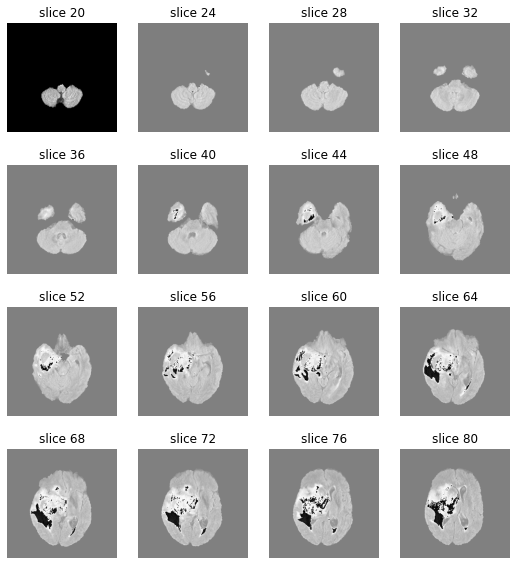

In [22]:
file_used= f'./fullimages_brain.npy'
imgs_to_process = np.load(file_used).astype(np.float64) 

def sample_stack(stack, rows=4, cols=4, start_with=20, show_every=4):
    fig,ax = plt.subplots(rows,cols,figsize=[9,10])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title(f'slice {ind}')
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

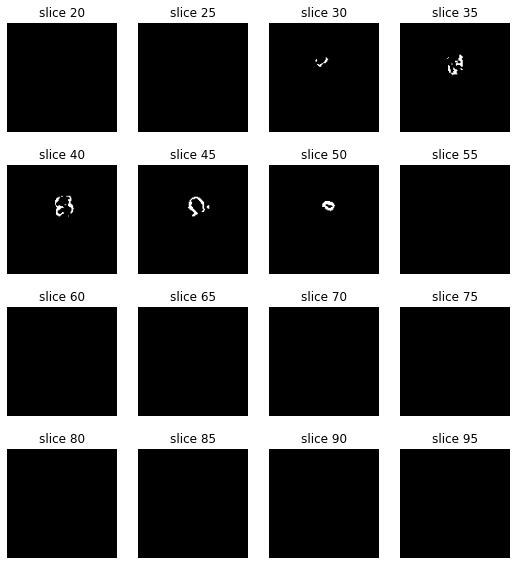

In [23]:
def sample_stack(stack, rows=4, cols=4, start_with=20, show_every=5):
    fig,ax = plt.subplots(rows,cols,figsize=[9,10])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title(f'slice {ind}')
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(tumor)

# Resampling the tumor and brain files

In [24]:
file_used= f'./fullimages_brain.npy'
imgs_to_process = np.load(file_used).astype(np.float64)
print(f'Shape before resampling: {imgs_to_process.shape}')
imgs_after_resamp = resample(imgs_to_process, [1,1,1])
print(f'Shape after resampling: {imgs_after_resamp.shape}')
spac = 100/len(imgs_to_process)
spac2 = 128/imgs_to_process.shape[1]
tumor= resample(tumor,[spac,spac2,spac2])
print('Tumor after reshape:',tumor.shape)

Shape before resampling: (155, 240, 240)
Shape after resampling: (155, 240, 240)
Tumor after reshape: (155, 240, 240)


# Creating mesh for 3D visualisation

In [25]:
def make_mesh(image,istransp='true', threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True)
    
    return verts, faces

In [26]:
def plotly_3d(verts, faces, verts2, faces2):
    x,y,z = zip(*verts) 
    x2,y2,z2 = zip(*verts2)
       
    
#     Make the colormap single color since the axes are positional not intensity. 
    colormap=['rgba(255, 0, 0,0.5)','rgba(255, 0, 0,0.5)']
    
    fig = ff.create_trisurf(x=x, y=y, z=z, plot_edges=False,
                        colormap=colormap,
                        show_colorbar=False,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    
    
    colormap2=['rgba(0, 255, 0,0.8)','rgba(0, 255, 0,0.8)']
    
    fig2 = ff.create_trisurf(x=x2, y=y2, z=z2, plot_edges=False,
                        colormap=colormap2,
                        show_colorbar=False,
                        simplices=faces2,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    fig['data'][0].update(opacity=0.2)
    
    



    
    data = [fig.data[0],fig2.data[0]]
    


    fig3 = dict(data=data)
    
    iplot(fig3)

In [27]:
imgs_after_resamp.shape

(155, 240, 240)

In [28]:
tumor = tumor*255.0

In [29]:
tumor.shape

(155, 240, 240)

In [30]:
np.max(imgs_after_resamp)

327.0000000000005

In [31]:
np.max(tumor)

378.67282

In [32]:
v, f = make_mesh(imgs_after_resamp,istransp=True, threshold = 20) #350 previously default value
v2, f2 = make_mesh(tumor,istransp=False, threshold = 50) #350 previously default value

Transposing surface
Calculating surface
Transposing surface
Calculating surface


# Plotting the 3D Visualization

In [33]:
'''Due to memory restrictions on github we could not run this cell and upload our notebook.
We have attached a drive link which contains the jupyter notebook with this cell run.'''
# plotly_3d(v, f,v2,f2)

'Due to memory restrictions on github we could not run this cell and upload our notebook.\nWe have attached a drive link which contains the jupyter notebook with this cell run.'

# An alternative approach to volume calculation

In [34]:
liver_volume = ConvexHull(v).volume /1000
tumor_volume = ConvexHull(v2).volume/1000
print('Liver volume:',liver_volume,'Tumor Volume',tumor_volume)

Liver volume: 1549.6878445161965 Tumor Volume 47.679166025893885
